In [1]:
import pandas as pd
import numpy as np
import os
import gzip
import pickle
import re
import tqdm

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# Leitura do banco

In [2]:
cnpjs = """
03.370.003/0001-05
08.912.569/0001-35
01.699.688/0001-02
17.329.581/0001-02
13.155.995/0001-01
08.046.355/0001-23
67.845.925/0001-04
26.695.100/0001-73
18.138.908/0001-21
02.832.973/0001-12
05.589.433/0001-48
""".split()

In [3]:
data_dir = "./"
db_file = 'fundos.db'
engine = create_engine(
    "sqlite:///"+os.path.abspath(os.path.join(data_dir, db_file)))

data_inicio = '2010-01-01'
data_fim = '2017-12-31'
cnpj_fundo = '13.155.995/0001-01'

In [4]:
# cotas
sqlquery = """
select VL_QUOTA, DT_COMPTC from inf_diario
where CNPJ_FUNDO = '{cnpj_fundo}'
and DT_COMPTC >= '{data_inicio}'
and DT_COMPTC <= '{data_fim}'
""".format(cnpj_fundo=cnpj_fundo, data_inicio=data_inicio, data_fim=data_fim)
cotas = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_COMPTC']).set_index(
    "DT_COMPTC")['VL_QUOTA'].sort_index()

In [5]:
# carteira e pesos
sqlquery = """
select * from cda
where CNPJ_FUNDO = '{cnpj_fundo}'
and DT_COMPTC >= '{data_inicio}'
and DT_COMPTC <= '{data_fim}'
""".format(cnpj_fundo=cnpj_fundo, data_inicio=data_inicio, data_fim=data_fim)
carteira = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_COMPTC'])
pl = carteira.sort_values(['DT_COMPTC', 'FILE'])[
    'VL_PATRIM_LIQ'].fillna(method='bfill')
carteira['VL_PATRIM_LIQ'] = pl
carteira['peso'] = carteira['VL_MERC_POS_FINAL'].div(carteira['VL_PATRIM_LIQ'])

carteira = carteira[carteira.FILE != 'PL']

# Valores a pagar são negativos
q = (carteira.TP_APLIC == 'Valores a pagar') | (
    carteira.TP_APLIC.str.lower().str.contains('obriga|lançad'))
carteira.loc[q, ['VL_MERC_POS_FINAL', 'peso']] *= -1

pivot_cols = carteira.CD_ATIVO\
    .fillna(carteira.CD_ISIN)\
    .fillna(carteira[carteira.FILE.str.contains('BLC_8') & carteira.TP_ATIVO.str.contains("Ação|Ações|Outr|Recibo|BDR", flags=re.IGNORECASE)].DS_ATIVO.str.extract(r'([A-Z]{4,5}\d+\d?)', expand=False))\
    .fillna(carteira[carteira.FILE.str.contains('BLC_8') & carteira.TP_ATIVO.str.contains("Opção|Opcões", flags=re.IGNORECASE)].DS_ATIVO.str.extract(r'([A-Z]{4,5}\d+\d?)', expand=False))\
    .fillna(carteira[carteira.TP_ATIVO.str.contains("Debênture", flags=re.IGNORECASE)].CD_INDEXADOR_POSFX)\
    .fillna(carteira[carteira.TP_APLIC.str.lower().isin(['disponibilidades', 'valores a pagar', 'valores a receber'])].TP_APLIC.str.upper())\
    .fillna(carteira[carteira.TP_ATIVO.str.contains('T.tulo p.blico federal', flags=re.IGNORECASE)].DS_ATIVO.str.extract("(BR..........)", expand=False))\
    .fillna(carteira[carteira.TP_ATIVO.str.contains('T.tulo p.blico federal', flags=re.IGNORECASE)].DS_ATIVO.str.extract(r'(\d{6})', expand=False))\
    .fillna(carteira.CNPJ_FUNDO_COTA)\
    .fillna(carteira.CD_ATIVO_BV_MERC)\
    .fillna(carteira[(carteira.TP_ATIVO.str.contains(r'Contrato Futuro.*', flags=re.IGNORECASE)) & (carteira.DS_ATIVO.str.contains('IND'))].DS_ATIVO.str.extract('(IND)', expand=False))\
    .fillna(carteira.DS_ATIVO)\
    .fillna(carteira.DS_INDEXADOR_POSFX)
print("Ativos sem identificação:", pivot_cols.isna().sum())

nome_fundo = carteira.DENOM_SOCIAL.unique()[0]
print(nome_fundo)

Ativos sem identificação: 0
DAYCOVAL IBOVESPA ATIVO FUNDO DE INVESTIMENTO EM AÇÕES


In [6]:
pivot_cols.loc[carteira.TP_ATIVO.str.contains('Futuro')] = pivot_cols[carteira.TP_ATIVO.str.contains('Futuro')].str.extract(r"(IND|DI1|WIN|DOL).*(\w\d\d)").apply(lambda x: 'F'.join(x), axis=1)

In [7]:
sqlquery = """
SELECT CNPJ_FUNDO,DT_COMPTC, VL_QUOTA from inf_diario
WHERE CNPJ_FUNDO in ('{cnpj_fundos}')
and DT_COMPTC >= '{data_inicio}'
and DT_COMPTC <= '{data_fim}'
""".format(cnpj_fundos="','".join(pivot_cols.unique()), data_inicio=data_inicio, data_fim=data_fim)
fundos_qry = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_COMPTC'])

In [8]:
# acoes
sqlquery = """
select * from cotacoes
WHERE CODNEG in ('{ativos}')
OR CODISI in ('{ativos}')
and DATA >= '{data_inicio}'
and DATA <= '{data_fim}'
""".format(ativos="','".join(pivot_cols.unique()), data_inicio=data_inicio, data_fim=data_fim)
acoes_qry = pd.read_sql_query(sqlquery, engine, parse_dates=['DATA'])

In [9]:
# ajustes desdobramentos
grupamentos = pd.read_parquet("grupamentos.parquet")
grupamentos.loc[grupamentos.iloc[:,0] == 'DESDOBRAMENTO', '% / Fator de Grupamento'] = grupamentos.loc[grupamentos.iloc[:,0] == 'DESDOBRAMENTO', '% / Fator de Grupamento'].div(100).add(1)
grupamentos = grupamentos[grupamentos.Proventos.isin(['GRUPAMENTO','DESDOBRAMENTO'])]

for data, fator, ativo in tqdm.tqdm_notebook(grupamentos[grupamentos['Código ISIN'].isin(acoes_qry.CODISI.unique())].iloc[:,[3,4,5]].to_records(index=False)):
    q = (acoes_qry.CODISI == ativo) & (acoes_qry.DATA <= data)
    c = ['PREABE', 'PREMAX', 'PREMIN', 'PREMED', 'PREULT','PREOFC', 'PREOFV']
    acoes_qry.loc[q,c] = acoes_qry.loc[q,c].div(fator)

In [10]:
# Titulos
sqlquery = """
select * from titulos_publicos
WHERE CODISI in ('{ativos}')
OR CODIGO in ('{ativos}')
and DT_MOV >= '{data_inicio}'
and DT_MOV <= '{data_fim}'
""".format(ativos="','".join(pivot_cols.unique()), data_inicio=data_inicio, data_fim=data_fim)
titulos_qry = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_MOV'])

In [11]:
# Futuros
sqlquery = """
select DATE as DT_MOV, substr(MERCADORIA,0,4) || 'F' || VENCIMENTO as CODIGO, PRECO_ATUAL/PRECO_ANTERIOR - 1 as PCT_CHANGE, VARIACAO, PRECO_ATUAL from futuros
WHERE DT_MOV >= '{data_inicio}'
and DT_MOV <= '{data_fim}'
and substr(MERCADORIA,0,4) || 'F' || VENCIMENTO in ('{ativos}')
""".format(data_inicio=data_inicio, data_fim=data_fim, ativos="','".join(pivot_cols.unique()))
futuros_qry = pd.read_sql_query(sqlquery, engine, parse_dates=[
                                'DT_MOV'])  # .pivot_table(index='DT_MOV', columns='CODIGO', values='PCT_CHANGE').groupby(dict(futuros_carteira), axis=1).mean()
#futuros_qry[['MERCADORIA','MES_VENCIMENTO', 'ANO_VENCIMENTO']] = futuros_qry.CODIGO.str.extract(r"(.*)_(.)(..)")

In [12]:
# Indice Futuro
sqlquery = """
select DATE as DT_MOV, MERCADORIA,substr(MERCADORIA,0,4) || 'F' || VENCIMENTO as CODIGO, PRECO_ATUAL/PRECO_ANTERIOR - 1 as PCT_CHANGE, VARIACAO, PRECO_ATUAL from futuros
WHERE DT_MOV >= '{data_inicio}'
and DT_MOV <= '{data_fim}'
and MERCADORIA == 'IND - Ibovespa'
""".format(data_inicio=data_inicio, data_fim=data_fim)
ibovfut_query = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_MOV'])

# Calcula os retornos dos ativos e dos títulos

In [13]:
retornos_acoes = acoes_qry.query("TPMERC == 10").pivot_table(index='DATA', columns='CODNEG', values='PREULT').div(100).pct_change()
retornos_titulos = titulos_qry.pivot_table(index='DT_MOV', columns='CODISI', values='VALOR_PAR').pct_change()
retornos_opcoes = acoes_qry.query("TPMERC != 10").pivot_table(index='DATA', columns='CODNEG', values='PREULT').div(100).pct_change()
retornos_fundos = fundos_qry.pivot_table(index='DT_COMPTC', columns='CNPJ_FUNDO',values='VL_QUOTA').pct_change()
#retornos_futuros = futuros_qry.pivot_table(index='DT_MOV', columns='CODIGO', values='PCT_CHANGE')
#retornos_ibov = ibovfut_query.pivot_table(index='DT_MOV', columns='CODIGO', values='VARIACAO').div(100000).mean(1)

### Ativos na carteira sem série de retornos

In [14]:
sem_id = set(pivot_cols) - set(retornos_acoes) - set(retornos_titulos) - set(retornos_fundos)\
- set() - set(retornos_opcoes)
print(len(sem_id), "ativos sem séries de retorno.", '\n\r', '\n, '.join(sorted(sem_id)))

15 ativos sem séries de retorno. 
 DISPONIBILIDADES
, KLABIN - DIREITO DE SUBSCRICAO
, KLABIN S/A DIR DEB N1
, LOQJD2
, LOQJD46
, LOQJD53
, OPERACOES COMPROMISSADAS - 01/07/2020 - LTN
, OPERACOES COMPROMISSADAS - 15/05/2055 - NTN - B
, OPERACOES COMPROMISSADAS - 15/08/2022 - NTN - B
, OQJUD1
, TÍTULOS PUBLICOS - 01/03/2020 - LFT
, TÍTULOS PUBLICOS - 01/03/2021 - LFT
, TÍTULOS PUBLICOS - 01/09/2020 - LFT
, VALORES A PAGAR
, VALORES A RECEBER


In [15]:
n_ativos = pivot_cols.nunique()
n_ativos_sem_id = len(sem_id)

# Agrupamento das ações por classe e agrupamento dos pesos

In [16]:
retornos_acoes_empresa = retornos_acoes.groupby(lambda s: s[0:4], axis=1).median().replace(0,np.nan)

In [17]:
# tratamento outliers
q = retornos_acoes_empresa.abs() < retornos_acoes_empresa.std()*6
retornos_acoes_empresa = retornos_acoes_empresa[q].fillna(
    retornos_acoes_empresa.rolling(3, center=True).median())

In [18]:
agrupamentos = retornos_acoes.groupby(lambda s: s[0:4], axis=1).count().max()
agrupamentos = agrupamentos[agrupamentos > 1].sort_values()
agrupamentos[~agrupamentos.index.isin(retornos_acoes_empresa.columns)]

Series([], dtype: int64)

In [19]:
# Calcula pesos da carteira
pesos = carteira.pivot_table(
    index='DT_COMPTC', columns=pivot_cols, values='peso', aggfunc='sum')

# ajusta os títulos que foram listados apenas com a selic no bloco_8 do relatório à CVM
cod_selic_codigo_ISI_map = dict(
    titulos_qry[['CODIGO', 'CODISI']].drop_duplicates().applymap(str).values)
pesos.rename(columns=cod_selic_codigo_ISI_map, inplace=True)

In [20]:
# agrupa acoes
classes = pd.read_excel("classificao_acoes.xlsx", encoding='latin1')
classes.columns = ['SETOR', 'SUBSETOR',
                   'SEGMENTO', 'EMPRESA', 'CODIGO', 'SEGMENTO.1']
classes_acoes = dict(classes[['CODIGO', 'SETOR']].values)
mapper = pd.Series(dict(zip(retornos_acoes.columns.str.slice(0,4),
                  retornos_acoes.columns.str.slice(0, 4).map(classes_acoes.get))))

pesos_acoes = pesos.reindex(columns=retornos_acoes.columns).fillna(0).groupby(lambda s: s[:4], axis=1).sum()
pesos_agregados_acoes = pesos_acoes.groupby(mapper, axis=1).sum()

retornos_agregados_acoes = retornos_acoes_empresa.groupby(mapper, axis=1).mean()

In [21]:
# agrupa titulos
pesos_titulos = pesos.reindex(columns=retornos_titulos.columns).fillna(0)
pesos_agregados_titulos = pd.Series(pesos_titulos.sum(1), name='Titulos')

retornos_agregados_titulos = pd.Series(
    retornos_titulos.mean(1), name='Titulos')

In [22]:
n_ativos_unicos = pd.concat([pivot_cols,  carteira[['DT_COMPTC']]], axis=1).groupby('DT_COMPTC')['CD_ATIVO'].nunique()

In [23]:
pesos_opcoes_conhecidas = pesos.reindex(columns=retornos_opcoes.columns)
pesos_agregados_opcoes_conhecidas = pd.Series(pesos_opcoes_conhecidas.sum(axis=1), name='Opções')

pesos_desconhecidos = pesos.reindex(columns=sem_id)
pesos_agregados_desconhecidos = pd.Series(pesos_desconhecidos.sum(axis=1), name='Desconhecidos')

pesos_fundos = pesos.reindex(columns=retornos_fundos.columns)
pesos_agregados_fundos = pd.Series(pesos_fundos.sum(axis=1), name='Fundos')

# FUTUROS
#pesos_futuros = pesos.reindex(columns=retornos_futuros.columns).fillna(0)
#pesos_agregados_futuros = pesos_futuros.groupby(lambda c: c[0:4], axis=1).sum()
#retornos_agregados_futuros = retornos_futuros.groupby(lambda c: c[0:4], axis=1).mean()

### Verifica se os dados contemplam todos ativos da carteira e se os pesos somam 1


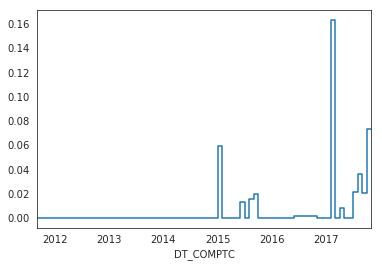

In [24]:
pesos_desconhecidos.drop(['DISPONIBILIDADES','VALORES A PAGAR','VALORES A RECEBER'], axis=1).sum(1).abs().plot(drawstyle='steps')

# Single Step Kalman

In [25]:
pesos_single_step =  pd.concat([
    pesos_acoes,
    pesos_titulos,
    pesos_fundos, 
    pesos_agregados_desconhecidos
], axis=1)

retornos_single_step = pd.concat([
    retornos_acoes_empresa,
    retornos_titulos,
    retornos_fundos, 
    pd.Series().reindex_like(pesos_agregados_desconhecidos).fillna(0)
], axis=1)

In [26]:
# variacão da cota
measurements = ((cotas - cotas.shift())/cotas).dropna()
measurements = measurements.reindex(index=measurements.index.intersection(
    pd.date_range(pesos.index.min(), pesos.index.max())))

# estados
eom_pesos = pesos_single_step.resample('D').bfill().reindex(index=measurements.index).reindex(
    index=measurements.groupby(pd.Grouper(freq='M')).tail(1).index)

signals = retornos_single_step.reindex(
    index=measurements.index.values)

states = eom_pesos.reindex(
    columns=signals.columns, index=measurements.index)

corr_fazer_nada = states.fillna(method='pad').mul(signals).sum(axis=1).corr(measurements).round(4)
print(corr_fazer_nada)

0.9602


In [27]:
n_dim = len(states.columns)

from filterpy.kalman import KalmanFilter
from filterpy.common import Saver, inv_diagonal
import tqdm

kf = KalmanFilter(n_dim,2+ n_dim)
kf.F *= 1
kf.P = np.diag([0]*kf.dim_x)
kf.Q *= np.sqrt(0.04)


kf.x = states.iloc[0].fillna(0).values
kf.P = np.zeros(kf.dim_x)

s = Saver(kf)
state_mask = np.zeros(kf.dim_x)
Hs = []
Rs = []
Zs = []
epss = []
for i,dt in tqdm.tqdm_notebook(enumerate(measurements.index), total=len(measurements)):

    if dt in eom_pesos.index:
        state_mask = states.replace(0,np.nan).fillna(method='bfill', limit=1)
        state_mask = state_mask.isnull().mul(1).loc[dt].values
        H = np.vstack([signals.loc[dt].fillna(0).values.reshape(1,kf.dim_x), np.eye(kf.dim_x), np.ones(kf.dim_x)])
        R = np.eye(kf.dim_z)*1e-3
    else:
        #kf.H = np.vstack([signals.loc[dt].fillna(0).values.reshape(1,n_dim), np.diag(state_mask)]).astype(float)
        #kf.R = np.diag(np.hstack([np.array(1e-2), (state_mask * 0.05) + np.finfo(np.double).tiny])).astype(float)
        H = np.vstack([signals.loc[dt].fillna(0).values.reshape(1,kf.dim_x),  np.diag(state_mask), np.ones(kf.dim_x)]).astype(float)
        R = np.eye(kf.dim_z) * 0.3
        R[0,0] = 1e-3
        R[0,0] = 1e-5
    
    Z = np.hstack([measurements.loc[dt], states.loc[dt].fillna(0), 1])
    kf.H = H
    kf.R = R
    
    kf.predict()
    kf.update(Z)
    
    y, S = kf.y[[0]], kf.S[0,0].reshape(1,1)
    eps = np.dot(y.T, np.linalg.inv(S)).dot(y)
    epss.append(eps)
    
    s.save()
    #Hs.append(H)
    #Rs.append(R)
    #Zs.append(Z)

In [28]:
# correlação de não se fazer nada
nome_fundo = carteira.DENOM_SOCIAL.unique()[0]
corr_fazer_nada = states.fillna(method='pad').mul(signals).sum(axis=1).corr(measurements).round(4)
data_inicio = measurements.index.min().strftime("%d-%m-%Y")
data_fim =  measurements.index.max().strftime("%d-%m-%Y")
n_cotas = len(measurements)
n_alocacoes = len(eom_pesos)

In [29]:
estimativas = pd.DataFrame(s.x, index=measurements.index, columns=signals.columns)
corr_single_step = (estimativas * signals).sum(axis=1).corr(measurements)

Fundo | Correlacao <br> constante | Data <br> Inicio | Data <br> Fim | # <br> cotas | # <br> alocaçoes |  Correlação <br> 1 Passo
:--------:|:--------------:|:-------------:|:----------:|:---------:|:-------------:|:---:|
{{nome_fundo}}| {{corr_fazer_nada}} | {{data_inicio}} | {{data_fim}} | {{n_cotas}} | {{n_alocacoes}} |  {{ corr_single_step.round(4)}}

In [37]:
print(f"""
Fundo: \t\t\t{nome_fundo}
Correlação cte: \t{corr_fazer_nada}
Correlação kalman: \t{corr_single_step.round(4)}
Periodo Observado: \t{data_inicio} - {data_fim}
N obs cotas: \t\t{n_cotas}
N obs alocações: \t{n_alocacoes}
""")

#Salva os resultados 
import shelve
file_name = re.sub(r"\.|/|-",'',cnpj_fundo)
with shelve.open(f'resultados_{file_name}.pkl') as db:
    db['nome_fundo'] = nome_fundo
    db['cnpj_fundo'] = cnpj_fundo
    db['corr_fazer_nada'] = corr_fazer_nada
    db['corr_kalman'] = corr_single_step
    db['data_inicio'] = data_inicio
    db['data_fim'] = data_fim
    db['n_cotas'] = n_cotas
    db['n_alocacoes'] = n_alocacoes
    db['carteira'] = carteira
    db['pivot_cols'] = pivot_cols
    db['pesos'] = pesos
    db['pesos_agregados_acoes'] = pesos_agregados_acoes
    if 'retornos_acoes_empresa' in dir():
        db['retornos_acoes_empresa'] = retornos_acoes_empresa.columns.values
    if 'retornos_titulos' in dir():
        db['retornos_titulos'] = retornos_titulos.columns.values
    if 'retornos_opcoes' in dir():
        db['retornos_opcoes'] = retornos_opcoes.columns.values
    if 'retornos_fundos' in dir():
        db['retornos_fundos'] = retornos_fundos.columns.values
    if 'retornos_futuros' in dir():
        db['retornos_futuros'] = retornos_futuros.columns.values
    db['sem_id'] = sem_id
    db['measurements'] = measurements
    db['eom_pesos'] = eom_pesos
    db['signals'] = signals
    db['states'] = states
    db['estimativas'] = estimativas


Fundo: 			DAYCOVAL IBOVESPA ATIVO FUNDO DE INVESTIMENTO EM AÇÕES
Correlação cte: 	0.9602
Correlação kalman: 	0.9991
Periodo Observado: 	30-09-2011 - 30-11-2017
N obs cotas: 		1550
N obs alocações: 	75



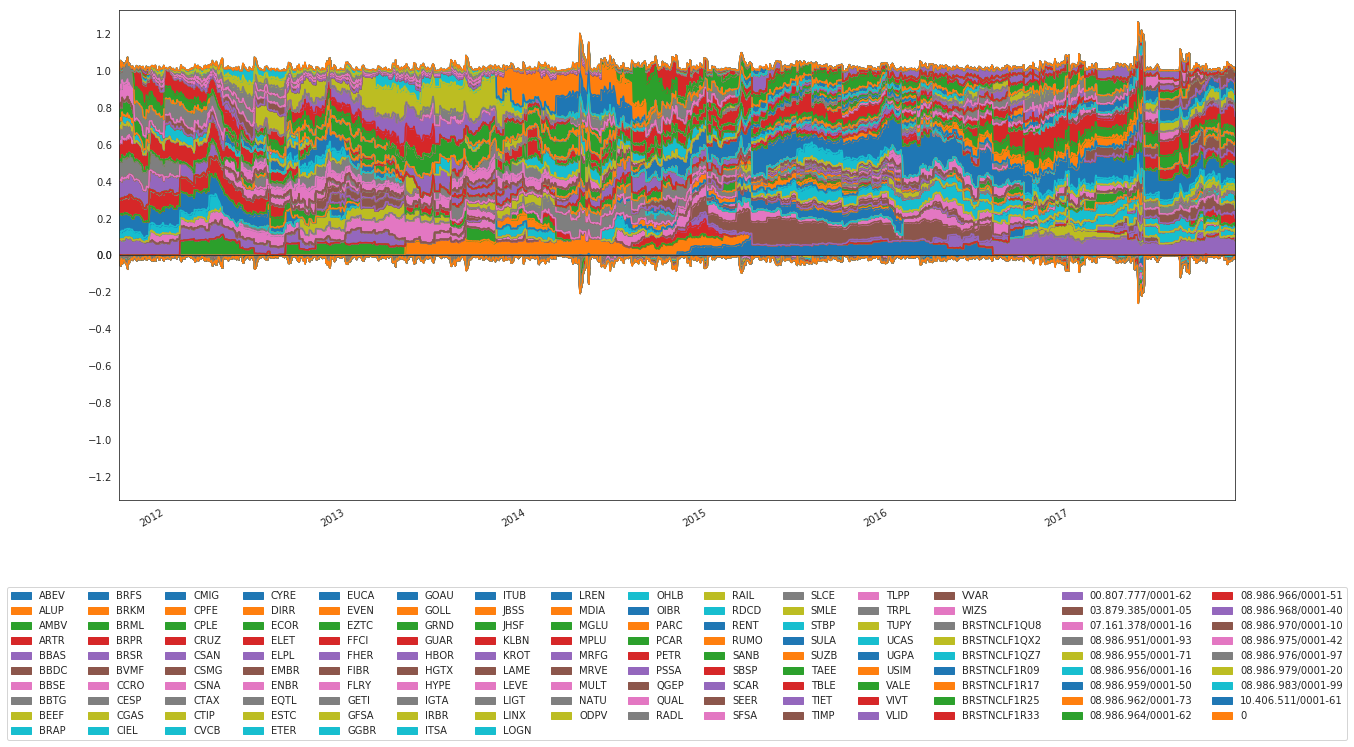

In [30]:
fig, (axu, axd) = plt.subplots(2, gridspec_kw=dict(hspace=0))
estimativas[(estimativas > 0)].reindex(columns=states.columns).plot.area(
    figsize=(20, 10), ax=axu, legend=None)
estimativas[(estimativas < 0)].reindex(
    columns=states.columns).plot.area(figsize=(20, 10), ax=axd)
axu.set_xticks([])
axd.set_ylim(-axu.get_ylim()[1], 0)
axd.legend(ncol=15, loc=8, bbox_to_anchor=(0.5, -1.0))

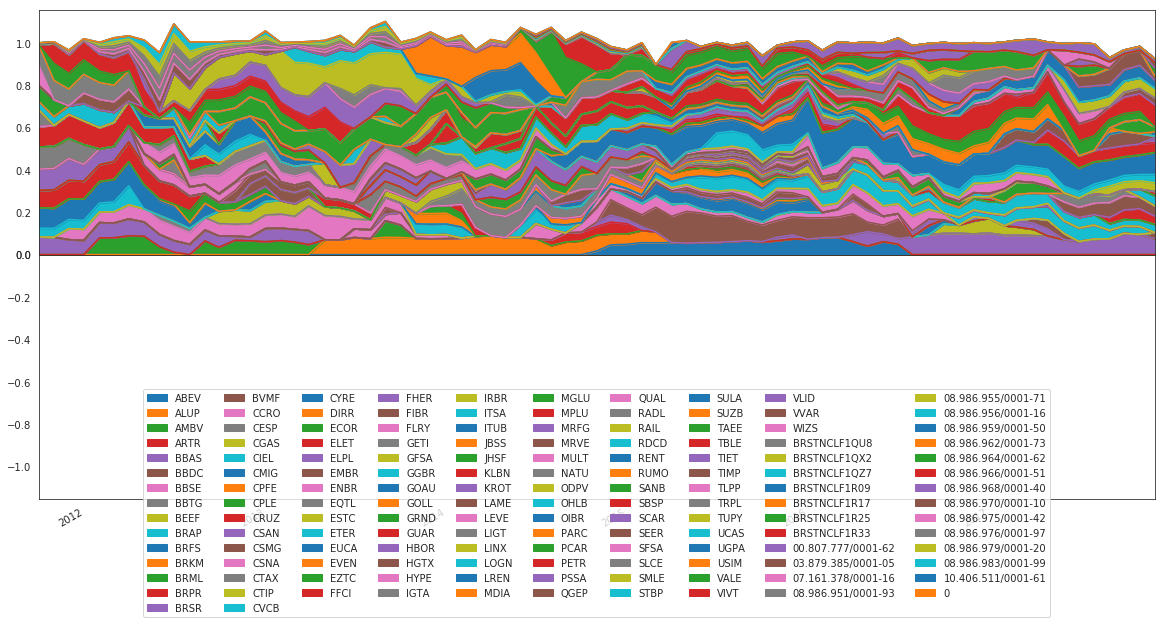

In [31]:
fig, (axu, axd) = plt.subplots(2, gridspec_kw=dict(hspace=0))
eom_pesos[(eom_pesos > 0)].reindex(columns=states.columns).plot.area(
    figsize=(20, 10), ax=axu, legend=None)
eom_pesos[(eom_pesos < 0)].reindex(
    columns=states.columns).plot.area(figsize=(20, 10), ax=axd)
axu.set_xticks([])
axd.set_ylim(-axu.get_ylim()[1], 0)
axd.legend(ncol=10, loc=8, bbox_to_anchor=(0.5, -0.5))

In [32]:
eom_pesos.max().sort_values(ascending=False).head(3)

BRSTNCLF1R25    0.212663
BRSTNCLF1R17    0.188045
BRSTNCLF1QX2    0.172807
dtype: float64

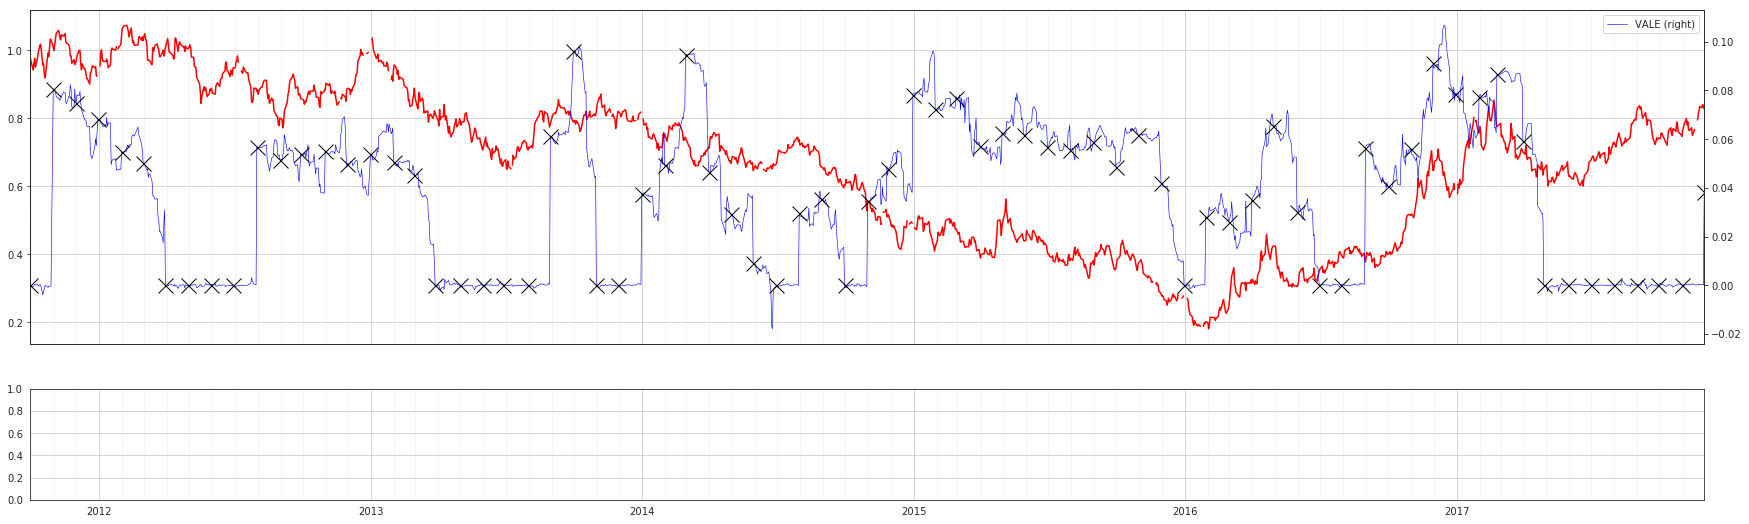

In [33]:
# verifica o ativo
%matplotlib inline

ativo = 'VALE'

fig, ax = plt.subplots(2, 1, figsize=(30, 10), sharex=True, gridspec_kw=dict(
    height_ratios=[3, 1], hspace=0.2), facecolor='white')
estimativas.loc[:, ativo].plot(
    secondary_y=True, color='Blue', legend='peso', ax=ax[0], lw=.6)

states[ativo].dropna().plot(marker='x', linestyle='', color='black',
                            markersize='15', secondary_y=True, ax=ax[0])
signals.loc[:, ativo].add(
    1).cumprod().plot(color='red', ax=ax[0])


import matplotlib.dates as mdates

ax[0].xaxis.set_minor_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_locator(mdates.YearLocator())
ax[0].grid(which='major', linestyle='-')
ax[0].grid(which='minor', linestyle=':', lw=.5)

ax[1].xaxis.set_minor_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_locator(mdates.YearLocator())
ax[1].grid(which='major', linestyle='-')
ax[1].grid(which='minor', linestyle=':', lw=.5)

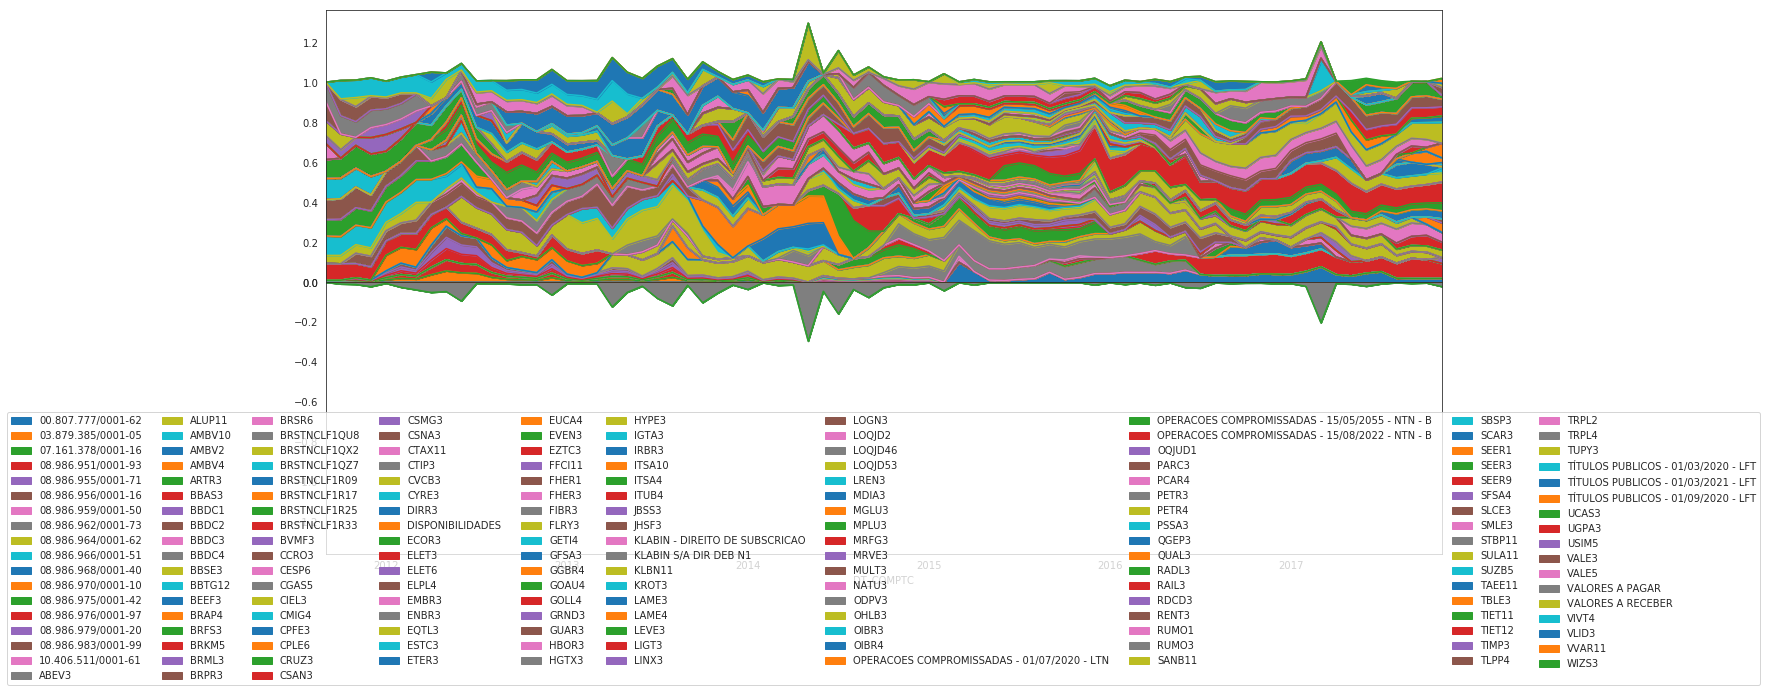

In [34]:
pesos = carteira.pivot_table(
    index='DT_COMPTC', columns=pivot_cols, values='peso', aggfunc='sum')

fig, (axu, axd) = plt.subplots(2, gridspec_kw=dict(hspace=0))
pesos[(pesos > 0)].plot.area(
    figsize=(20, 10), ax=axu, legend=None)
pesos[(pesos < 0)].plot.area(figsize=(20, 10), ax=axd)
axu.set_xticks([])
axd.set_ylim(-axu.get_ylim()[1], 0)
axd.legend(ncol=10, loc=8, bbox_to_anchor=(0.5, -0.5))

In [35]:
pesos

CD_ATIVO,00.807.777/0001-62,03.879.385/0001-05,07.161.378/0001-16,08.986.951/0001-93,08.986.955/0001-71,08.986.956/0001-16,08.986.959/0001-50,08.986.962/0001-73,08.986.964/0001-62,08.986.966/0001-51,...,UGPA3,USIM5,VALE3,VALE5,VALORES A PAGAR,VALORES A RECEBER,VIVT4,VLID3,VVAR11,WIZS3
DT_COMPTC,,,,,,,,,,,,,,,,,,,,,
2011-09-30,NaN,NaN,0.000927,NaN,0.000927,0.000927,0.000927,0.000927,0.000927,0.000927,...,NaN,NaN,NaN,NaN,-0.000996,0.001121,NaN,NaN,NaN,NaN
2011-10-31,NaN,NaN,0.000966,NaN,0.000965,0.000965,0.000965,0.000965,0.000965,0.000965,...,NaN,NaN,0.080791,NaN,-0.009804,0.003994,0.092324,NaN,NaN,NaN
2011-11-30,NaN,0.004364,NaN,0.004364,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.074804,NaN,-0.011599,0.045815,0.087646,NaN,NaN,NaN
2011-12-31,NaN,0.001992,NaN,0.001992,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.068365,NaN,-0.022889,0.003508,0.089940,NaN,NaN,NaN
2012-01-31,NaN,0.011155,NaN,0.011155,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.054939,NaN,-0.006387,0.003919,0.079725,NaN,NaN,NaN
2012-02-29,NaN,0.018904,NaN,0.018904,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.050296,NaN,-0.026300,0.002443,0.079150,NaN,NaN,NaN
2012-03-31,NaN,0.014926,NaN,0.014925,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,-0.038915,0.005680,0.091829,NaN,NaN,NaN
2012-04-30,NaN,0.036876,NaN,0.036875,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.051756,0.038543,0.081696,0.049658,NaN,NaN
2012-05-31,NaN,0.055958,NaN,0.055957,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.047272,0.091570,0.032412,0.000000,NaN,NaN
